![Astrofisica Computacional](../logo.PNG)

---
## 26. Validación cruzada del Árbol de Decisión 

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Resumen

En este cuaderno se introducirá el método de validación cruzada de los árboles de decisión.

---

Hasta este momento, se ha utilizado la mediana de los residuos para medir la precisión de la predicción. Este método básico, en el que se divide el conjunto de datos en subconjuntos de entrenamiento y prueba, es llamado **hold-out validation** (validación de retención) y el resultado de la precisión dependerá de como se dividen los subconjuntos.

Ahora, se introducirá un mejor método de validación denominado **k-fold cross-validation** (validación cruzada de k-combinaciones). Este es similar a la validación hold-out, excepto porque los datos originales se dividiran en k-subconjuntos y se entrenara el modelo k-veces, utilizando diferentes combinaciones de los subconjuntos y registrando la precisión en cada ocasión (i.e. se realizará una validación hold-out en k-ocasiones). 

En la práctica, en cada ocasión se utiliza una combinación diferente de k-1 subconjuntos para entrenar el modelo y el subconjunto restante se utiliza para la prueba del modelo. Luego, se toma el promedio de las precisiones de las k-mediciones para obtener la precisión global del modelo.

De nuevo utilizaremos el conjunto de datos fotométricos de galaxias, pero en esta ocasión introduciremos un aspecto adicional al estimar la precisión cuando el modelo se aplica a Quasi-Stellar Objects (QSOs) comparado con otras galaxias. Como es bien conocido, los QSOs son galaxias que poseen un núcleo activo (AGN), que hacen que la galxia sea más brillante y por lo tanto, detectable con los instrumentos del SDSS con corrimientos al rojo mas altos. 

### Cargando los Datos

Igual que antes, se utiliza el archivo `'sdss_galaxy_colors.npy`. 


In [1]:
import numpy as np

data = np.load('sdss_galaxy_colors.npy')
data

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

Las características contenidas en el archivo son

| dtype | Feature|
|:-:|:-:|
|`u` |u band filter|
|`g` |g band filter|
|`r` |r band filter|
|`i` |i band filter|
|`z` |z band filter|
|`spec_class` |spectral class|
|`redshift` |redshift|
|`redshift_err` |redshift error|


El número de muestras (galaxias) en el archivo es

In [2]:
n = data.size
n

50000

El primer paso es definir los conjuntos de entrada 'features' (indices de color) y 'targets' (corrimiento al rojo)

In [3]:
# Function returning the 4 color indices and the redshifts
import numpy as np

features, targets = np.asarray([data['u']-data['g'],\
                                data['g']-data['i'],\
                                data['r']-data['i'],\
                                data['i']-data['z']]), \
                    np.asarray(data['redshift'])

features = features.T

### K-Fold

Para hacer la división del conjunto en los k-subconjuntos se utilizará la función [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). La división se realiza definiendo un objeto iterable mediante el comando

```
kf = KFold(n_splits=k, shuffle=True)
```

donde el argumento `n_splits=k` especifica el número de subconjuntos que se utilizarán y el argumento  `shuffle` es puesto en Falso por defecto, pero es una buena práctica activarlo para que se eligan aleatoriamente los elementos de cada subconjunto (con ello se evita introducir una tendencia o parcialidad debido al orden en el que se presentan los datos dentro del archivo). 

Se utilizará la función `KFold` con un valor inicial de **k=5** y el árbol de decisión con una profundidad de   `max_depth=19` (de acuerdo con el resultado anterior para evitar el sobre-ajuste).

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
dec_tree = DecisionTreeRegressor(max_depth=21)

El método `.split()` se aplica al conjunto de características para generar los conjuntos de entrenamiento y prueba. Nótese que este método define solo el conjunto de índices correspondeintes a cada subconjunto, pero no el subconjunto como tal. Por esta razón, debemos tomar estos índices y definir los conjuntos adecuadamente para luego proceder a entrenar el modelo y evaluar su predicción mediante la mediana de los residuos.

Este proceso completo debe repetirse para cada una de las k-iteraciones. Para ello implementamos un loop  `for`,



In [5]:
# declare an array for predicted redshifts from each iteration
all_predictions = np.zeros_like(targets)

for train_indices, test_indices in kf.split(features):
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets   = targets[train_indices], targets[test_indices]

    # Train the decision tree
    dec_tree.fit(train_features, train_targets)
  
    # Predict using the model
    predictions = dec_tree.predict(test_features)

    # put the predicted values in the all_predictions array defined above
    all_predictions[test_indices] = predictions



# Evaluate the model using the median of differences of all_predictions
eval_dec_tree = np.median(np.abs(all_predictions - targets)) 
eval_dec_tree

0.018139481207719896

Una vez que se entrena el modelo y se calculan las predicciones, se pueden comparar gráficamente las predicciones y los datos 'target'


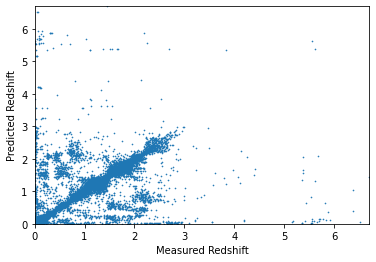

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

# plot the results to see how well our model looks
plt.figure()
plt.scatter(targets, all_predictions, s=0.4)
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

El resultado debe lucir como la siguiente figura:
<center>
<img src="https://groklearning-cdn.com/modules/SjroKib6Hs5Fqxq53Vxme9/predicted_v_measured.png" width=450>
</center>
Nótese que en este gráfico de predicciones contra mediciones se observa un buen comportamiento para muchas galaxias, pero también exiten muchos puntos fuera de la tendencia (outliers).

---
### Clase Espectral 

La característica 'spec_class' en el conjunto de datos involucra dos posibles valores b'GALAXY' y b'QSO', que identifican a las galaxias y a los Quasi-Stellar Objects (QSOs), respectivamente.

**1. Defina una función que clasifique las muestras de acuerdo con el 'spec_class'.**

In [7]:
def ClassifyData(data, feature, value):
    '''
    ------------------------------------------
    ClassifyData()
    ------------------------------------------
    Create a subset of a numpy array. The cri-
    terium is take all the elements such column
    `feature` has the value 'value'.
    
    Input:
        data:    the array to be classified 
        feature: the name of the column in that
                 we will compare with value
        value:   the value to filter
        
    Output: 
        data_classified: a subset of the 
        original array
    ------------------------------------------
    '''
    data_classified = data[data[feature] == value]
    
    return data_classified

Para ver si el método funciona, comparemos el conjunto de datos original con los subconjuntos de datos de galaxias y de QSO, i.e.,

In [8]:
# Original data
display(data)

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [9]:
# Select elements such `spec_class` feature is b'GALAXY'
data_galaxy = ClassifyData(data=data, feature='spec_class', value=b'GALAXY')
data_galaxy

array([(19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       (19.05989, 17.49459, 16.59285, 16.09412, 15.70741, b'GALAXY', 0.04427702, 1.062687e-05),
       ...,
       (18.78195, 17.36771, 16.62808, 16.24659, 15.97817, b'GALAXY', 0.07815261, 3.072155e-05),
       (19.65251, 17.59881, 16.63644, 16.19178, 15.85334, b'GALAXY', 0.07943849, 1.990372e-05),
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [10]:
# Select elements such `spec_class` feature is b'QSO', i.e., Quasi-Stellar Object
data_QSO = ClassifyData(data=data, feature='spec_class', value=b'QSO')
data_QSO

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301 , 6.543622e-05),
       (18.27065, 18.08745, 18.08966, 18.2218 , 18.37045, b'QSO', 0.3965296, 5.659872e-02),
       (18.97039, 18.81752, 18.68532, 18.60291, 18.3335 , b'QSO', 2.084146 , 4.871592e-04),
       ...,
       (19.76299, 19.62001, 19.38377, 19.39635, 19.4131 , b'QSO', 1.363022 , 6.827491e-04),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295 , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449, 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

**2. Cuantas galaxias y cuantos QSOs existen en el archivo?**

Como hemos creado arreglos para el subconjunto de galaxias y el subconjunto de QSOs, solo resta ver el tamaño de esos arreglos, i.e.,

In [11]:
print(f'En el archivo `sdss_galaxy_colors.npy` '
      f'hay {data_galaxy.size} galaxias y '
      f'{data_QSO.size} objetos cuasi-estelares.')

En el archivo `sdss_galaxy_colors.npy` hay 41475 galaxias y 8525 objetos cuasi-estelares.


**3. Calcular la mediana de los residuos para galaxias y QSOs. Cuáles son los valores máximos de estas diferencias para los dos tipos de objetos?**


Las galaxias no son tan brillantes como los QSOs y por ello son muy débiles para ser detectados por el SDSS si poseen un redshift superior a 0.4. Esto crea una parcialidad en las mediciones.

Usando lo que se vio al principio de este cuaderno de notas, vamos a crear un método que calcule la predicción del $z$ para un subconjunto del arreglo `data` y otro método que calcule la mediana de los residuos para el mismo subconjunto.

In [24]:
def kCrossValidation(features, targets, k = 5, depth=21):
    import numpy as np
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.model_selection import KFold

    # Create the subsets for the k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True)            
    dec_tree = DecisionTreeRegressor(max_depth = depth)

    # declare an array for predicted redshifts from each iteration
    all_predictions = np.zeros_like(targets)

    for train_indices, test_indices in kf.split(features):
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets   = targets[train_indices], targets[test_indices]

        # Train the decision tree
        dec_tree.fit(train_features, train_targets)

        # Predict using the model
        predictions = dec_tree.predict(test_features)

        # put the predicted values in the all_predictions array defined above
        all_predictions[test_indices] = predictions
    
    return all_predictions

def MedianCrossValidation(all_predictions, targets):
    # Evaluate the model using the median of differences of all_predictions
    eval_dec_tree = np.median(np.abs(all_predictions - targets)) 
    
    return eval_dec_tree

Y ahora llamemos a este método `kCrossValidation()` para los subconjuntos de las galaxias y de los QSOs,

In [25]:
# Separate the galaxy data between features and targets
features_galaxy, targets_galaxy = np.asarray([data_galaxy['u'] - data_galaxy['g'],\
                                              data_galaxy['g'] - data_galaxy['i'],\
                                              data_galaxy['r'] - data_galaxy['i'],\
                                              data_galaxy['i'] - data_galaxy['z']]), \
                                  np.asarray(data_galaxy['redshift'])
features_galaxy = features_galaxy.T

# call the method to compute the prediction z
predictions_galaxy = kCrossValidation(features_galaxy, targets_galaxy)
m_galaxy = MedianCrossValidation(all_predictions = predictions_galaxy,
                                 targets = targets_galaxy)

m_galaxy

0.01742866

In [26]:
# Separate the QSO data between features and targets
features_QSO, targets_QSO = np.asarray([data_QSO['u'] - data_QSO['g'],\
                                        data_QSO['g'] - data_QSO['i'],\
                                        data_QSO['r'] - data_QSO['i'],\
                                        data_QSO['i'] - data_QSO['z']]), \
                            np.asarray(data_QSO['redshift'])
features_QSO = features_QSO.T

# call the method to compute the prediction z and the median
predictions_QSO = kCrossValidation(features_QSO, targets_QSO)
m_QSO = MedianCrossValidation(all_predictions = predictions_QSO,
                              targets = targets_QSO)
m_QSO

0.07932733333333353

Note que he generado la mediana como un escalar y no como un vector. Esto es porque, a mi parecer, los parámetros a variar para calcular la mediana son el número de particiones $k$ y la profundidad `max_depth`. Sin embargo, la profundidad es fija (21 en mi caso para no generar sobre ajuste) y el número de particiones $k$ no me permite generar una función mediana vs redshift, que es lo nos interesa para el ínciso 4.

En resumen, no estoy seguro de cómo calcular un vector de mediana en función del redshift (medido). A menos que genere múltiples ruidos aleatorios sobre el redshifht para poder hacer estadística, no estoy seguro.

**4. Realice un gráfico con la mediana de los residuos vs. Redshift medido para todos los objetos del conjunto y utilice un color para identificar galaxias y otro color para los QSOs.**

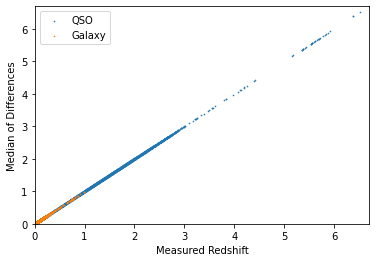

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()

plt.scatter(targets_QSO, targets_QSO, label="QSO", s=0.4)          # en y deberíamos tener la mediana y = m_QSO
plt.scatter(targets_galaxy, targets_galaxy, label="Galaxy", s=0.4) # en y deberíamos tener la mediana y = m_galaxy

plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Median of Differences')
plt.legend()
plt.show()

**5. Realice un nuevo gráfico con las predicciones vs mediciones de corrimiento al rojo, identificando el tipo de objeto con colorse diferentes. El resultado debe ser similar a este:**

<center>
<img src="https://groklearning-cdn.com/modules/ovFSymwFkqBPAcjnbSUxLG/predicted_actual_qso.png" width=450>
</center>



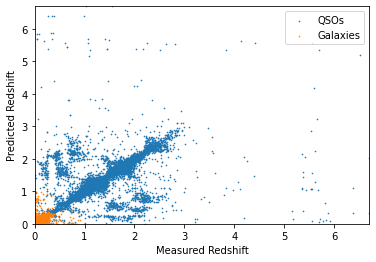

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

# plot the results to see how well our model looks
plt.figure()
plt.scatter(targets_QSO, predictions_QSO, label='QSOs', s=0.4)
plt.scatter(targets_galaxy, predictions_galaxy, label='Galaxies', s=0.4)

plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.legend()
plt.show()